In [1]:
import numpy as np
import tensorflow as tf

## Setting up a simple meta-learning environment

In [2]:
class SinusoidEnv():
    
    def __init__(self, amp_low=2.0, amp_high=4.0, x_shift_low=-2.0, x_shift_high=2.0,
                 x_low=-4.0, x_high=4.0, noise_std=0.1, seed=234):
        self.amp_low = amp_low
        self.amp_high = amp_high
        self.x_shift_low = x_shift_low
        self.x_shift_high = x_shift_high
        self.x_low = x_low
        self.x_high = x_high
        self.noise_std = noise_std
        self.random_state = np.random.RandomState(seed)

    def _sample_sinusoid_fn(self):
        amplitude = np.random.uniform(self.amp_low, self.amp_high)
        x_shift = np.random.uniform(self.x_shift_low, self.x_shift_high)
        return lambda x: amplitude * np.sin((x - x_shift)) + 5.0

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples

### Generate meta-train and meta-test data

In [3]:
env = SinusoidEnv()
meta_train_data = env.generate_meta_train_data(n_tasks=100, n_samples=5)
meta_test_data = env.generate_meta_test_data(n_tasks=20, n_samples_context=5,n_samples_test=200)

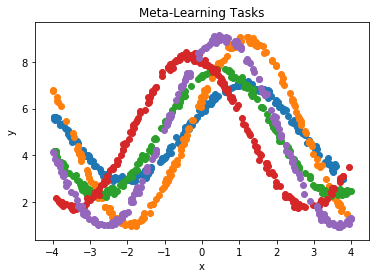

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
for x_context, y_context, x_test, y_test in meta_test_data[:5]:
    plt.scatter(x_test, y_test)
plt.title('Meta-Learning Tasks')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Training a Standard Bayesian Neural Network 

100%|██████████| 500/500 [00:02<00:00, 175.30it/s, loss=55.7, avg_ll=-76.1, avg_rmse=2.81, cal_err=0.196]


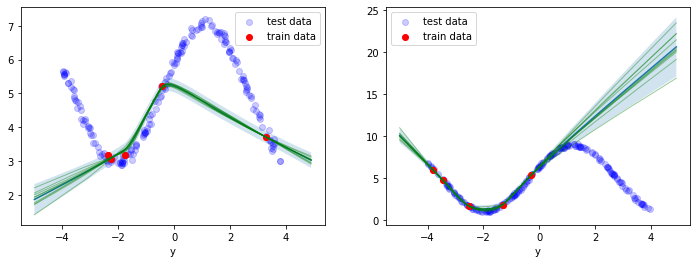

In [5]:
import warnings
import warnings
warnings.filterwarnings("ignore")

from bnn import BayesianNeuralNetworkSVGD

fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # setting up and fitting the BNN
    bnn = BayesianNeuralNetworkSVGD(x_context, y_context, hidden_layer_sizes=(64, 64), prior_weight=0.001, bandwidth=1000.0)
    bnn.fit(x_val=x_test, y_val=y_test, num_iter_fit=500, log_period=500)
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    bnn.plot_predictions(x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

## Meta-Learning a BNN Prior with PACOH-NN

### Meta-Training

Start meta-training -------------------- 


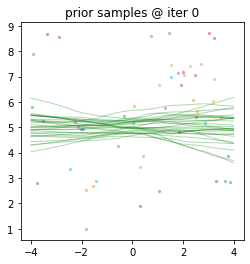


Iter 0/20000 - Time 32.47 sec - Train-Loss: -19613.51562

Iter 1000/20000 - Time 16.67 sec - Train-Loss: -399.48441

Iter 2000/20000 - Time 16.70 sec - Train-Loss: -839.48633

Iter 3000/20000 - Time 17.73 sec - Train-Loss: -375.56067

Iter 4000/20000 - Time 16.88 sec - Train-Loss: -403.15756


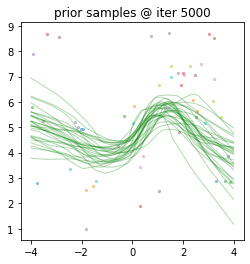


Iter 5000/20000 - Time 17.35 sec - Train-Loss: -329.51358

Iter 6000/20000 - Time 16.79 sec - Train-Loss: -273.24841

Iter 7000/20000 - Time 16.44 sec - Train-Loss: -198.25879

Iter 8000/20000 - Time 16.52 sec - Train-Loss: -153.08507

Iter 9000/20000 - Time 17.82 sec - Train-Loss: -66.48532


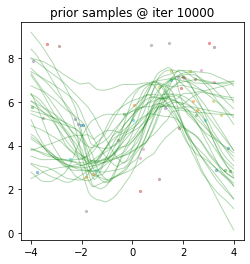


Iter 10000/20000 - Time 17.25 sec - Train-Loss: -47.88253

Iter 11000/20000 - Time 20.78 sec - Train-Loss: -40.84458

Iter 12000/20000 - Time 17.43 sec - Train-Loss: -46.55365

Iter 13000/20000 - Time 16.54 sec - Train-Loss: -45.99514

Iter 14000/20000 - Time 16.66 sec - Train-Loss: -37.65415


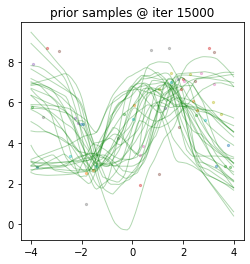


Iter 15000/20000 - Time 16.94 sec - Train-Loss: -40.59324

Iter 16000/20000 - Time 16.88 sec - Train-Loss: -42.92769

Iter 17000/20000 - Time 16.53 sec - Train-Loss: -41.46867

Iter 18000/20000 - Time 16.68 sec - Train-Loss: -39.32176

Iter 19000/20000 - Time 17.04 sec - Train-Loss: -36.40613


In [7]:
from pacoh.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, random_seed=22, num_iter_meta_train=20000,
                                     learn_likelihood=True, likelihood_std=0.1)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=5000, log_period=1000, 
                        plot_prior_during_training=True, plot_period=5000)

### Meta-Testing

100%|██████████| 3000/3000 [00:17<00:00, 170.12it/s, loss=-59.7]


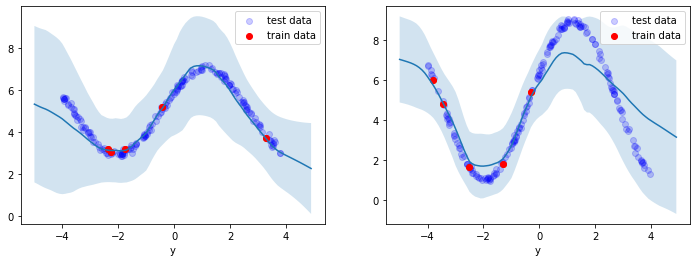

In [11]:
pacoh_model.num_iter_meta_test = 3000
pacoh_model.prior_weight = 0.01
fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    pacoh_model.plot_posterior(x_context, y_context, x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

eval_metrics_mean, eval_metrics_std = meta_reg_model.meta_eval_datasets(meta_val_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f"%(key, eval_metrics_mean[key], eval_metrics_std[key]))